In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("../data/insurance.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 50 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      1000098 non-null  object 
 9   AccountType               1000098 non-null  object 
 10  MaritalStatus             1000098 non-null  object 
 11  Gender                    1000098 non-null  object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

Convert categorical data into a numeric format using one-hot encoding or label encoding to make it suitable for modeling.

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Drop constant columns
drop_cols = ['Language', 'Country', 'ItemType', 'StatutoryClass', 'StatutoryRiskType']
df.drop(columns=drop_cols, inplace=True)

# Label Encoding for binary columns
label_cols = ['Gender', 'AlarmImmobiliser', 'TrackingDevice', 'WrittenOff',
              'Rebuilt', 'Converted', 'TermFrequency']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Optional: Label encode TransactionMonth (or extract year/month separately)
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
df['Month'] = df['TransactionMonth'].dt.month
df['Year'] = df['TransactionMonth'].dt.year
df.drop(columns=['TransactionMonth'], inplace=True)

# Optional: Convert VehicleIntroDate to month and year
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], errors='coerce')
df['VehicleIntroYear'] = df['VehicleIntroDate'].dt.year
df['VehicleIntroMonth'] = df['VehicleIntroDate'].dt.month
df.drop(columns=['VehicleIntroDate'], inplace=True)

# One-hot encoding
one_hot_cols = ['Citizenship', 'LegalType', 'Title', 'Bank', 'AccountType', 'MaritalStatus',
                'Province', 'MainCrestaZone', 'SubCrestaZone', 'VehicleType', 'make',
                'bodytype', 'NewVehicle', 'ExcessSelected', 'CoverCategory', 'CoverType',
                'CoverGroup', 'Section', 'Product']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)


In [6]:
# Convert mmcode to float
df['mmcode'] = pd.to_numeric(df['mmcode'], errors='coerce')
print(df['mmcode'].dtype)
df['mmcode'].isna().sum()  # See how many were invalid

float64


552

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Columns: 269 entries, UnderwrittenCoverID to Product_Standalone Passenger Liability
dtypes: bool(242), float64(11), int32(4), int64(11), object(1)
memory usage: 421.6+ MB


In [8]:
df_claims_clean = df[df['TotalClaims'] > 0].copy()

# Drop columns that are irrelevant or already processed(PolicyID, UnderwrittenCoverID are identifiers)
drop_ids_and_processed = ['PolicyID', 'UnderwrittenCoverID']
df_claims_clean.drop(columns=[col for col in drop_ids_and_processed if col in df_claims_clean.columns], inplace=True)

df_claims_clean = df_claims_clean.dropna(thresh=len(df_claims_clean) * 0.9, axis=1)
df_claims_clean = df_claims_clean.dropna()

if 'RegistrationYear' in df_claims_clean.columns:
    df_claims_clean['VehicleAge'] = 2025 - df_claims_clean['RegistrationYear']
    df_claims_clean.drop(columns=['RegistrationYear'], inplace=True) # Drop original year as 'VehicleAge' replaces it

# if any 'object' or 'category' dtypes still exist that need encoding.
remaining_categorical_cols = df_claims_clean.select_dtypes(include=['object', 'category']).columns

if len(remaining_categorical_cols) > 0:
    print(f"Warning: Found remaining categorical columns: {remaining_categorical_cols}. Applying one-hot encoding again.")
    df_claims_clean = pd.get_dummies(df_claims_clean, columns=remaining_categorical_cols, drop_first=True)
else:
    print("No remaining object/category columns found. Data is numeric or already encoded.")

# Define features (X) and target (y)
X_claim_severity = df_claims_clean.drop('TotalClaims', axis=1)
y_claim_severity = df_claims_clean['TotalClaims']

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_claim_severity, y_claim_severity, test_size=0.2, random_state=42
)

print("\nShape of training data for Claim Severity:")
print(f"X_train_sev: {X_train_sev.shape}")
print(f"y_train_sev: {y_train_sev.shape}")
print(f"X_test_sev: {X_test_sev.shape}")
print(f"y_test_sev: {y_test_sev.shape}")


Shape of training data for Claim Severity:
X_train_sev: (2220, 403)
y_train_sev: (2220,)
X_test_sev: (555, 403)
y_test_sev: (555,)


### Claim Severity Prediction using Regression Models

### Linear Regression

Linear Regression Performance (Claim Severity):
 RMSE: 34656.14
 R² Score: 0.1566


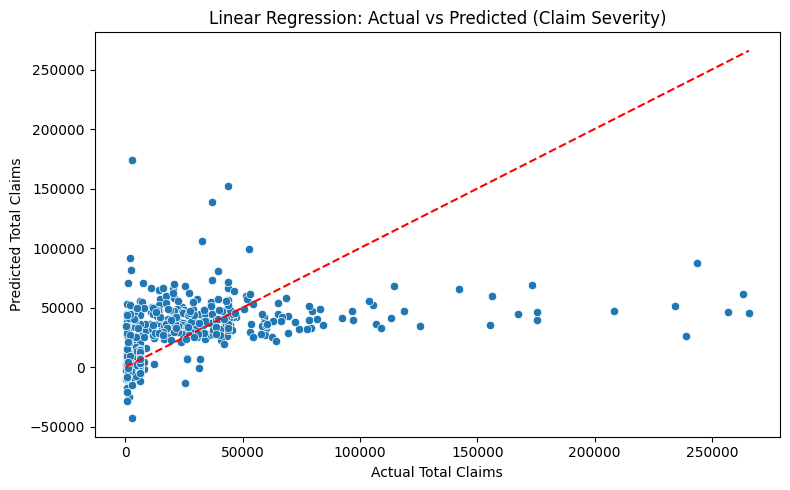

In [9]:
lr_model = LinearRegression()
lr_model.fit(X_train_sev, y_train_sev)

# Predict
y_pred_lr = lr_model.predict(X_test_sev) # Changed variable name for clarity

# Evaluation
rmse_lr = np.sqrt(mean_squared_error(y_test_sev, y_pred_lr))
r2_lr = r2_score(y_test_sev, y_pred_lr)

print(f"Linear Regression Performance (Claim Severity):")
print(f" RMSE: {rmse_lr:.2f}")
print(f" R² Score: {r2_lr:.4f}")

# Visualize
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_sev, y=y_pred_lr)
plt.xlabel("Actual Total Claims")
plt.ylabel("Predicted Total Claims")
plt.title("Linear Regression: Actual vs Predicted (Claim Severity)")
# range of actual test values for the reference line
plt.plot([y_test_sev.min(), y_test_sev.max()], [y_test_sev.min(), y_test_sev.max()], 'r--')
plt.tight_layout()
plt.show()

### Random Forest

Random Forest Performance (Claim Severity):
RMSE: 33593.65
R² Score: 0.2076


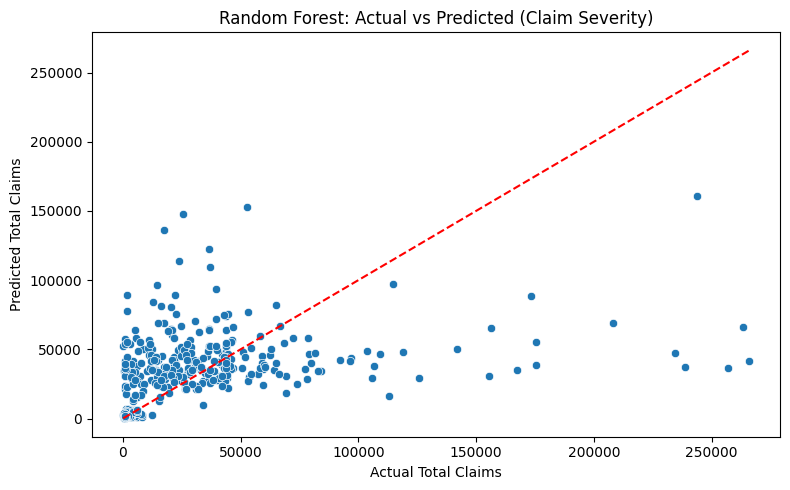

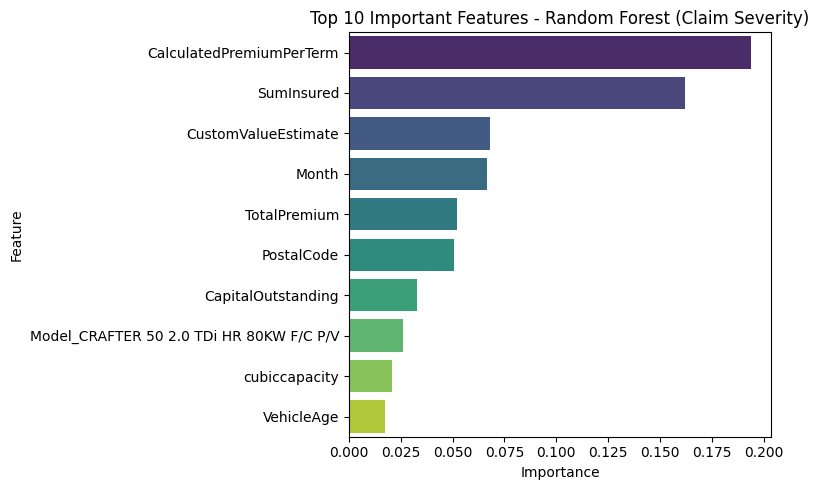

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train_sev, y_train_sev)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_sev) # Changed variable name for clarity

# Evaluation metrics
rf_rmse = np.sqrt(mean_squared_error(y_test_sev, y_pred_rf))
rf_r2 = r2_score(y_test_sev, y_pred_rf)

print(f"Random Forest Performance (Claim Severity):")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R² Score: {rf_r2:.4f}")

# Visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_sev, y=y_pred_rf)
plt.xlabel("Actual Total Claims")
plt.ylabel("Predicted Total Claims")
plt.title("Random Forest: Actual vs Predicted (Claim Severity)")
plt.plot([y_test_sev.min(), y_test_sev.max()], [y_test_sev.min(), y_test_sev.max()], 'r--')
plt.tight_layout()
plt.show()

# Feature Importances (Random Forest)
importances = rf_model.feature_importances_
feature_names = X_train_sev.columns # Use X_train_sev here
rf_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(data=rf_importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Important Features - Random Forest (Claim Severity)")
plt.tight_layout()
plt.show()

### XGBoost

In [11]:
# !pip install xgboost

XGBoost Performance (Claim Severity):
 RMSE: 34678.30
 R² Score: 0.1556


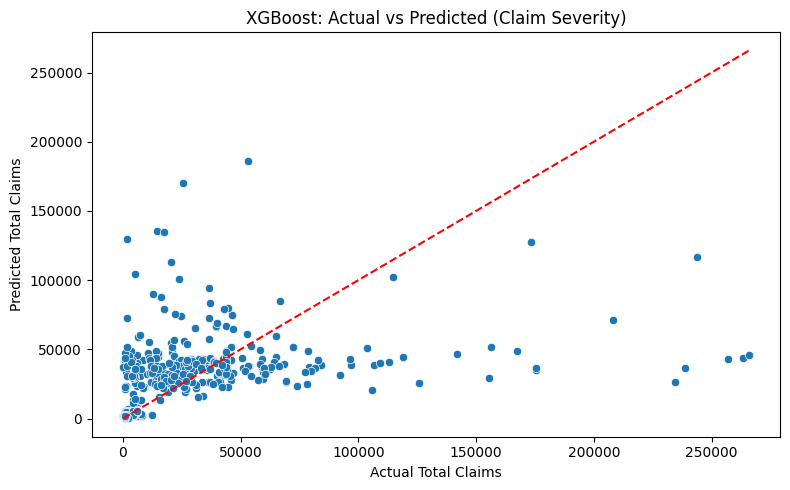

In [12]:
import xgboost as xgb

# Initialize and train model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_sev, y_train_sev)

# Predict
y_pred_xgb = xgb_model.predict(X_test_sev) # Changed variable name for clarity

# Evaluation
xgb_rmse = np.sqrt(mean_squared_error(y_test_sev, y_pred_xgb))
xgb_r2 = r2_score(y_test_sev, y_pred_xgb)

print(f"XGBoost Performance (Claim Severity):")
print(f" RMSE: {xgb_rmse:.2f}")
print(f" R² Score: {xgb_r2:.4f}")

# Visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_sev, y=y_pred_xgb)
plt.xlabel("Actual Total Claims")
plt.ylabel("Predicted Total Claims")
plt.title("XGBoost: Actual vs Predicted (Claim Severity)")
plt.plot([y_test_sev.min(), y_test_sev.max()], [y_test_sev.min(), y_test_sev.max()], 'r--')
plt.tight_layout()
plt.show()

### Model Interpretability (SHAP) for the Best Claim Severity Model

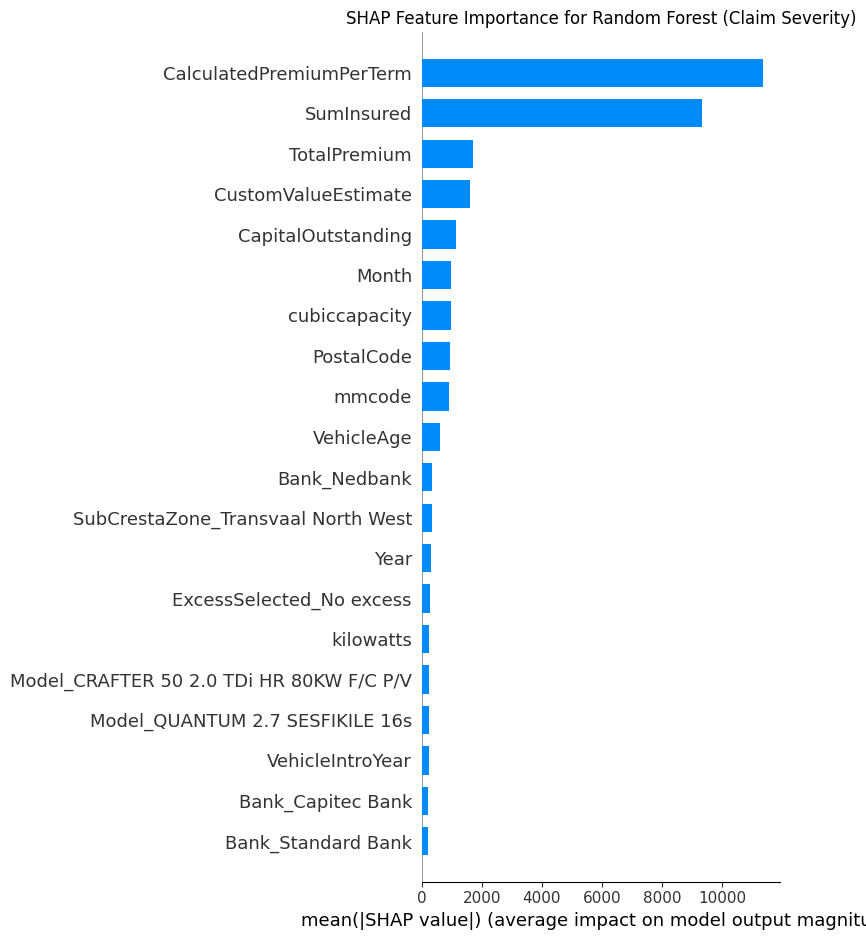


Top 10 Most Influential Features (Claim Severity):
                      feature  shap_abs_mean
17   CalculatedPremiumPerTerm   11351.334734
15                 SumInsured    9335.989601
18               TotalPremium    1713.549182
8         CustomValueEstimate    1605.936249
11         CapitalOutstanding    1144.271261
19                      Month     978.409527
5               cubiccapacity     972.462176
2                  PostalCode     943.869714
3                      mmcode     893.485733
264                VehicleAge     610.510097


In [13]:
import shap
best_severity_model = rf_model
best_severity_model_name = "Random Forest"
X_test_for_shap = X_test_sev # Use the test features for the best model

explainer = shap.TreeExplainer(best_severity_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_for_shap)

shap.summary_plot(shap_values, X_test_for_shap, plot_type="bar", show=False)
plt.title(f"SHAP Feature Importance for {best_severity_model_name} (Claim Severity)")
plt.tight_layout()
plt.show()

# Get top features for interpretation
shap_df = pd.DataFrame({
    'feature': X_test_for_shap.columns,
    'shap_abs_mean': np.abs(shap_values).mean(axis=0)
})
top_features = shap_df.sort_values(by='shap_abs_mean', ascending=False).head(10)
print("\nTop 10 Most Influential Features (Claim Severity):")
print(top_features)

### Regression Model Comparison

The table below compares performance of regression models in predicting `TotalClaims` or `LossRatio`.

- **RMSE (Root Mean Squared Error)**: Penalizes large errors, lower is better.
- **R² (R-squared)**: Measures how well variance in target is explained (1.0 is best).


In [26]:
regression_results = pd.DataFrame([
    {"Model": "Linear Regression", "RMSE": 34656.14, "R2": 0.1566},
    {"Model": "Random Forest Regressor", "RMSE": 33593.65, "R2": 0.2076},
    {"Model": "XGBoost Regressor", "RMSE": 34678.30, "R2": 0.1556}
])

regression_results

,Model,RMSE,R2
0,Linear Regression,34656.14,0.1566
1,Random Forest Regressor,33593.65,0.2076
2,XGBoost Regressor,34678.30,0.1556


### Probability of Claim using Classification Models

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

df['has_claim'] = (df['TotalClaims'] > 0).astype(int)

drop_for_classification = [
    'TotalClaims',
    'TotalPremium',
    'PolicyID',
    'UnderwrittenCoverID',
]

features_df_classification = df.drop(columns=[col for col in drop_for_classification if col in df.columns], errors='ignore')

if 'RegistrationYear' in features_df_classification.columns:
    features_df_classification['VehicleAge'] = 2025 - features_df_classification['RegistrationYear']
    features_df_classification.drop(columns=['RegistrationYear'], inplace=True)
else:
    print("Warning: 'RegistrationYear' not found in features_df_classification to create 'VehicleAge'. Assuming 'VehicleAge' was handled otherwise or is not needed.")

remaining_categorical_cols_for_clf = features_df_classification.select_dtypes(include=['object', 'category']).columns

if len(remaining_categorical_cols_for_clf) > 0:
    print(f"Warning: Found remaining categorical columns for classification: {remaining_categorical_cols_for_clf}. Applying one-hot encoding.")
    features_df_classification = pd.get_dummies(features_df_classification, columns=remaining_categorical_cols_for_clf, drop_first=True)
else:
    print("No remaining object/category columns found for classification. Data is numeric or already encoded.")

if 'has_claim' in features_df_classification.columns:
    X_clf_final = features_df_classification.drop('has_claim', axis=1)
    y_clf_final = features_df_classification['has_claim']
else:
    y_clf_final = df['has_claim'].loc[features_df_classification.index]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf_final, y_clf_final, test_size=0.2, random_state=42, stratify=y_clf_final
)

print("\nShape of training data for Probability of Claim (Classification):")
print(f"X_train_clf: {X_train_clf.shape}")
print(f"y_train_clf: {y_train_clf.shape}")
print(f"X_test_clf: {X_test_clf.shape}")
print(f"y_test_clf: {y_test_clf.shape}")

print("\n'has_claim' distribution in training set:")
print(y_train_clf.value_counts(normalize=True))
print("\n'has_claim' distribution in test set:")
print(y_test_clf.value_counts(normalize=True))


Shape of training data for Probability of Claim (Classification):
X_train_clf: (800078, 675)
y_train_clf: (800078,)
X_test_clf: (200020, 675)
y_test_clf: (200020,)

'has_claim' distribution in training set:
has_claim
0    0.997213
1    0.002787
Name: proportion, dtype: float64

'has_claim' distribution in test set:
has_claim
0    0.99721
1    0.00279
Name: proportion, dtype: float64


In [15]:
import pandas as pd
import numpy as np

print("Original training set sizes:")
print(y_train_clf.value_counts())

# Separate majority and minority classes
df_train_clf = X_train_clf.copy()
df_train_clf['has_claim'] = y_train_clf

df_majority = df_train_clf[df_train_clf['has_claim'] == 0]
df_minority = df_train_clf[df_train_clf['has_claim'] == 1]

num_minority_samples = len(df_minority)
num_majority_to_keep = num_minority_samples * 3 # Keeping 3 times more majority samples than minority

if num_majority_to_keep > len(df_majority):
    num_majority_to_keep = len(df_majority) # Do not sample more than available

df_majority_downsampled = df_majority.sample(n=int(num_majority_to_keep), random_state=42)

# Concatenate minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target from the downsampled training data
X_train_clf_sampled = df_downsampled.drop('has_claim', axis=1)
y_train_clf_sampled = df_downsampled['has_claim']

print("\nDownsampled training set sizes:")
print(y_train_clf_sampled.value_counts())
print(f"New X_train_clf_sampled shape: {X_train_clf_sampled.shape}")
print(f"New y_train_clf_sampled shape: {y_train_clf_sampled.shape}")

Original training set sizes:
has_claim
0    797848
1      2230
Name: count, dtype: int64

Downsampled training set sizes:
has_claim
0    6690
1    2230
Name: count, dtype: int64
New X_train_clf_sampled shape: (8920, 675)
New y_train_clf_sampled shape: (8920,)


### RandomForestClassifier

Random Forest Classifier Performance
 Accuracy: 0.7728
 Precision: 0.0113
 Recall: 0.9301
 F1-Score: 0.0223
 ROC AUC: 0.9029


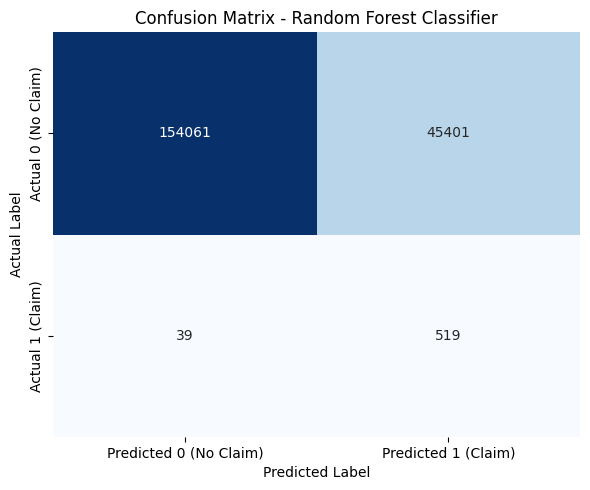

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

rf_clf_model = RandomForestClassifier(
    n_estimators=70,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Train the model using the SAMPLED training data
rf_clf_model.fit(X_train_clf_sampled, y_train_clf_sampled)

# Predict on test set
y_pred_rf_clf = rf_clf_model.predict(X_test_clf)
y_proba_rf_clf = rf_clf_model.predict_proba(X_test_clf)[:, 1]

# Evaluate the model
accuracy_rf_clf = accuracy_score(y_test_clf, y_pred_rf_clf)
precision_rf_clf = precision_score(y_test_clf, y_pred_rf_clf, zero_division=0)
recall_rf_clf = recall_score(y_test_clf, y_pred_rf_clf, zero_division=0)
f1_rf_clf = f1_score(y_test_clf, y_pred_rf_clf, zero_division=0)
roc_auc_rf_clf = roc_auc_score(y_test_clf, y_proba_rf_clf)
conf_matrix_rf_clf = confusion_matrix(y_test_clf, y_pred_rf_clf)

print(f"Random Forest Classifier Performance")
print(f" Accuracy: {accuracy_rf_clf:.4f}")
print(f" Precision: {precision_rf_clf:.4f}")
print(f" Recall: {recall_rf_clf:.4f}")
print(f" F1-Score: {f1_rf_clf:.4f}")
print(f" ROC AUC: {roc_auc_rf_clf:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf_clf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0 (No Claim)', 'Predicted 1 (Claim)'],
            yticklabels=['Actual 0 (No Claim)', 'Actual 1 (Claim)'])
plt.title('Confusion Matrix - Random Forest Classifier')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### XGBoost Classifier

Calculated scale_pos_weight: 3.00

XGBoost Classifier Performance (Probability of Claim):
 Accuracy: 0.7930
 Precision: 0.0125
 Recall: 0.9373
 F1-Score: 0.0246
 ROC AUC: 0.9094


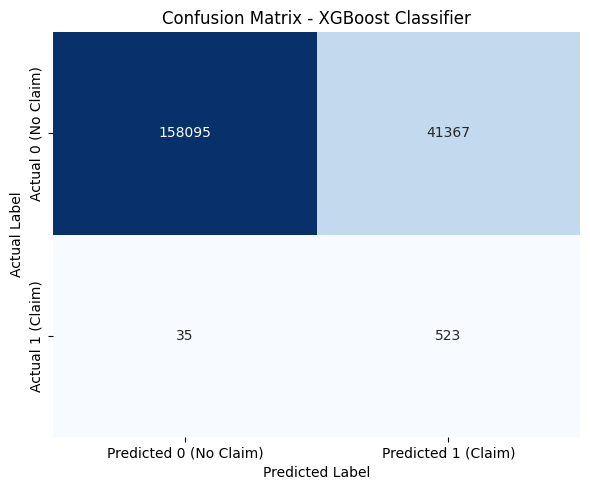

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate scale_pos_weight for XGBoost to imbalance by weighting the minority class more heavily
neg_count = y_train_clf_sampled.value_counts()[0]
pos_count = y_train_clf_sampled.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

# Initialize and train XGBoost Classifier
xgb_clf_model = XGBClassifier(
    objective='binary:logistic', # For binary classification
    eval_metric='logloss',       # Evaluation metric
    use_label_encoder=False,     # Suppress warning for future versions
    n_estimators=100,            # Number of boosting rounds
    learning_rate=0.1,           # Step size shrinkage
    max_depth=5,                 # Maximum depth of a tree, keep it relatively small for memory
    subsample=0.8,               # Subsample ratio of the training instance
    colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
    gamma=0.1,                   # Minimum loss reduction required to make a further partition
    random_state=42,
    n_jobs=-1,                   # Use all available cores
    scale_pos_weight=scale_pos_weight_value # Address class imbalance
)

# Train the model using the SAMPLED training data
xgb_clf_model.fit(X_train_clf_sampled, y_train_clf_sampled)

# Predict on test set
y_pred_xgb_clf = xgb_clf_model.predict(X_test_clf)
y_proba_xgb_clf = xgb_clf_model.predict_proba(X_test_clf)[:, 1]

# Evaluate the model
accuracy_xgb_clf = accuracy_score(y_test_clf, y_pred_xgb_clf)
precision_xgb_clf = precision_score(y_test_clf, y_pred_xgb_clf, zero_division=0)
recall_xgb_clf = recall_score(y_test_clf, y_pred_xgb_clf, zero_division=0)
f1_xgb_clf = f1_score(y_test_clf, y_pred_xgb_clf, zero_division=0)
roc_auc_xgb_clf = roc_auc_score(y_test_clf, y_proba_xgb_clf)
conf_matrix_xgb_clf = confusion_matrix(y_test_clf, y_pred_xgb_clf)

print(f"\nXGBoost Classifier Performance (Probability of Claim):")
print(f" Accuracy: {accuracy_xgb_clf:.4f}")
print(f" Precision: {precision_xgb_clf:.4f}")
print(f" Recall: {recall_xgb_clf:.4f}")
print(f" F1-Score: {f1_xgb_clf:.4f}")
print(f" ROC AUC: {roc_auc_xgb_clf:.4f}")

# Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb_clf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0 (No Claim)', 'Predicted 1 (Claim)'],
            yticklabels=['Actual 0 (No Claim)', 'Actual 1 (Claim)'])
plt.title('Confusion Matrix - XGBoost Classifier')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Classification Model Comparison

Below is a performance comparison of the classification models (Random Forest and XGBoost) based on standard metrics:

- **Accuracy**: Overall correctness
- **Precision**: Ability to avoid false positives
- **Recall**: Ability to detect true positives
- **F1-score**: Harmonic mean of precision and recall


In [23]:
classification_results = pd.DataFrame([
    {"Model": "Random Forest", "Accuracy": 0.7728, "Precision": 0.0113, "Recall": 0.9301, "F1": 0.0223},
    {"Model": "XGBoost", "Accuracy": 0.7930, "Precision": 0.0125, "Recall": 0.9373, "F1": 0.0246}
])

classification_results

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.7728,0.0113,0.9301,0.0223
1,XGBoost,0.7930,0.0125,0.9373,0.0246


### Precision-Recall Curve

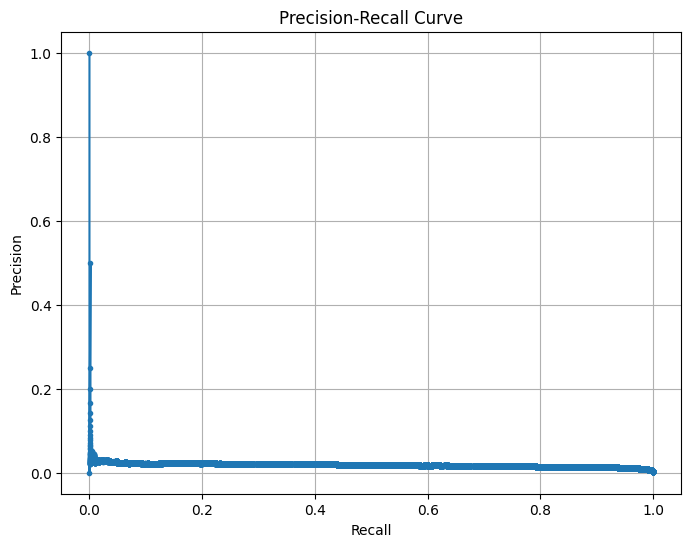

Evaluating metrics at different probability thresholds:

 Threshold: 0.5
  Precision: 0.0125
  Recall:    0.9373
  F1-Score:  0.0246
  Confusion Matrix:
[[158095  41367]
 [    35    523]]

 Best Threshold based on F1-Score: 0.9725
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  Confusion Matrix:
[[199461      1]
 [   558      0]]

 Threshold for High Precision Attempt (0.2)
  Precision: 0.0097
  Recall:    0.9767
  F1-Score:  0.0193
  Confusion Matrix:
[[144042  55420]
 [    13    545]]


In [19]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, precision_score, recall_score, f1_score

y_proba = y_proba_xgb_clf 
y_true = y_test_clf

# Get precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Evaluate metrics at different thresholds
print("Evaluating metrics at different probability thresholds:")

threshold_0_5 = 0.5
y_pred_0_5 = (y_proba >= threshold_0_5).astype(int)
print(f"\n Threshold: {threshold_0_5}")
print(f"  Precision: {precision_score(y_true, y_pred_0_5, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_true, y_pred_0_5, zero_division=0):.4f}")
print(f"  F1-Score:  {f1_score(y_true, y_pred_0_5, zero_division=0):.4f}")
print(f"  Confusion Matrix:\n{confusion_matrix(y_true, y_pred_0_5)}")


fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
best_threshold_f1 = thresholds[ix] if len(thresholds) > 0 else 0.5
print(f'\n Best Threshold based on F1-Score: {best_threshold_f1:.4f}')
y_pred_best_f1 = (y_proba >= best_threshold_f1).astype(int)
print(f"  Precision: {precision_score(y_true, y_pred_best_f1, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_true, y_pred_best_f1, zero_division=0):.4f}")
print(f"  F1-Score:  {f1_score(y_true, y_pred_best_f1, zero_division=0):.4f}")
print(f"  Confusion Matrix:\n{confusion_matrix(y_true, y_pred_best_f1)}")

threshold_high_precision = 0.2 # Adjust this after viewing the Precision-Recall curve
if len(thresholds) > 0 and threshold_high_precision > thresholds.min() and threshold_high_precision < thresholds.max():
    y_pred_high_precision = (y_proba >= threshold_high_precision).astype(int)
    print(f"\n Threshold for High Precision Attempt ({threshold_high_precision})")
    print(f"  Precision: {precision_score(y_true, y_pred_high_precision, zero_division=0):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred_high_precision, zero_division=0):.4f}")
    print(f"  F1-Score:  {f1_score(y_true, y_pred_high_precision, zero_division=0):.4f}")
    print(f"  Confusion Matrix:\n{confusion_matrix(y_true, y_pred_high_precision)}")
else:
    print(f"\nNote: Cannot evaluate threshold {threshold_high_precision}. It might be outside the range of calculated thresholds.")

### Implement Model Interpretability (SHAP)


Global Feature Importance (SHAP Bar Plot - Probability of Claim):


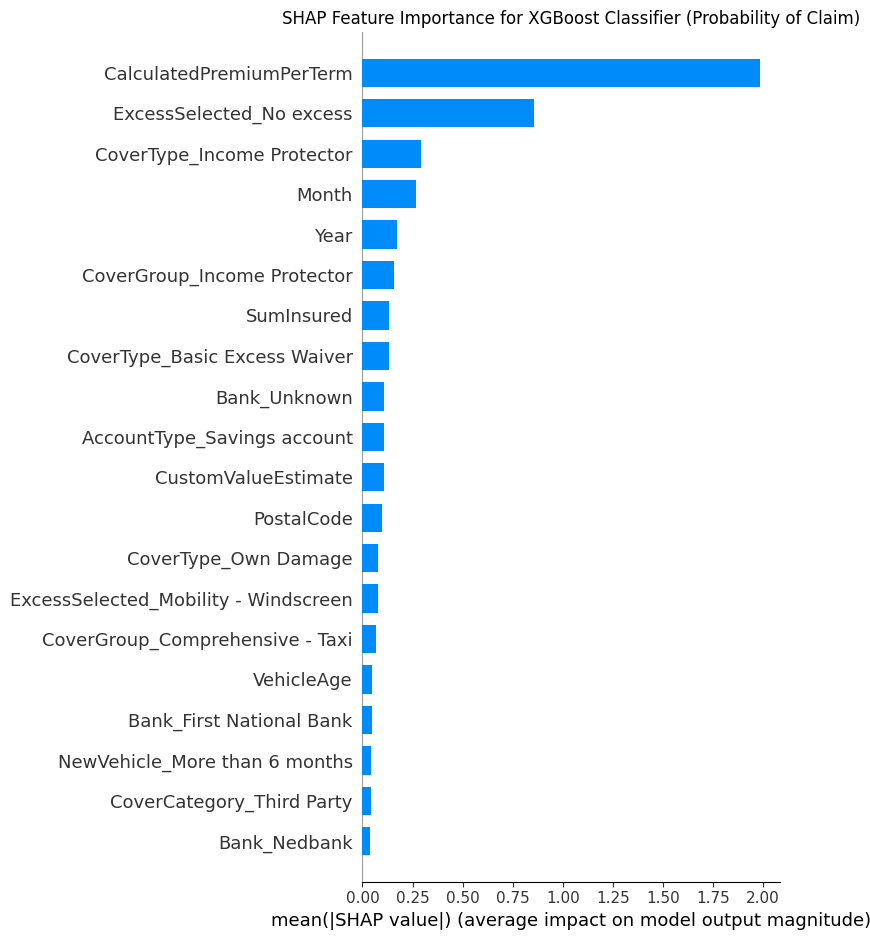


Top 10 Most Influential Features (Probability of Claim):
                           feature  shap_abs_mean
17        CalculatedPremiumPerTerm       1.984973
194       ExcessSelected_No excess       0.857686
232     CoverType_Income Protector       0.292431
18                           Month       0.268544
19                            Year       0.174196
251    CoverGroup_Income Protector       0.159149
15                      SumInsured       0.134287
224  CoverType_Basic Excess Waiver       0.130672
44                    Bank_Unknown       0.108736
45     AccountType_Savings account       0.106440


In [20]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# XGBoost Classifier
best_probability_model = xgb_clf_model
best_probability_model_name = "XGBoost Classifier"

num_shap_samples = 10000 
if len(X_test_clf) > num_shap_samples:
    X_test_for_shap_clf = X_test_clf.sample(n=num_shap_samples, random_state=42)
else:
    X_test_for_shap_clf = X_test_clf # Use full test set if it's smaller than desired sample size

# Create a TreeExplainer for tree-based models
explainer_clf = shap.TreeExplainer(best_probability_model)

# Calculate SHAP values
shap_values_clf = explainer_clf.shap_values(X_test_for_shap_clf)

# Ensure shap_values_clf is a single array if it's a list of arrays (common for multi-output explainers)
if isinstance(shap_values_clf, list):
    shap_values_clf_positive_class = shap_values_clf[1]
else:
    shap_values_clf_positive_class = shap_values_clf


print("\nGlobal Feature Importance (SHAP Bar Plot - Probability of Claim):")
shap.summary_plot(shap_values_clf_positive_class, X_test_for_shap_clf, plot_type="bar", show=False)
plt.title(f"SHAP Feature Importance for {best_probability_model_name} (Probability of Claim)")
plt.tight_layout()
plt.show()



# 10 most influential features based on mean absolute SHAP value
shap_df_clf = pd.DataFrame({
    'feature': X_test_for_shap_clf.columns,
    'shap_abs_mean': np.abs(shap_values_clf_positive_class).mean(axis=0)
})
top_features_clf = shap_df_clf.sort_values(by='shap_abs_mean', ascending=False).head(10)
print("\nTop 10 Most Influential Features (Probability of Claim):")
print(top_features_clf)

## Summary & Recommendation

#### Classification
- XGBoost performs slightly better than Random Forest, with higher accuracy (0.7930) and F1-score (0.0246).
- Both models show very high recall (>93%) but extremely low precision, meaning they detect most high-risk customers but with many false positives.
- *Recommendation*: Use XGBoost if catching all risky clients is critical, but improve precision through threshold tuning or class balancing.

#### Regression
- All regression models have low R² (≤ 0.21), indicating poor predictive power.
- Random Forest Regressor performs best with lowest RMSE (33,593).
- *Recommendation*: Use only for rough claim value estimates. Better features or segmentation may improve results.


##### Deploy XGBoost for classification with caution. Use Random Forest Regressor for basic severity ranking, not precise prediction.
